In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from tool import *

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
for batch in train_iter:
    print(batch)

(tensor([[ 1,  9,  1,  ..., 10,  1,  8],
        [ 1,  3,  9,  ..., 12,  4,  8],
        [ 5,  6, 18,  ..., 11,  1,  9],
        ...,
        [12, 12,  1,  ...,  2,  6,  1],
        [ 2,  1,  3,  ..., 15,  2,  1],
        [ 1,  9,  2,  ..., 11, 10,  2]]), tensor([[ 9,  1, 18,  ...,  1,  8,  7],
        [ 3,  9,  4,  ...,  4,  8,  8],
        [ 6, 18,  2,  ...,  1,  9,  5],
        ...,
        [12,  1, 14,  ...,  6,  1,  4],
        [ 1,  3, 10,  ...,  2,  1,  4],
        [ 9,  2,  1,  ..., 10,  2, 17]]))
(tensor([[ 7,  1,  5,  ...,  1,  7, 16],
        [ 8,  2,  8,  ...,  1,  2, 13],
        [ 5,  8,  1,  ...,  4, 11,  7],
        ...,
        [ 4,  3,  1,  ...,  8,  9,  2],
        [ 4,  6, 11,  ...,  9,  5,  8],
        [17,  1, 14,  ..., 12, 19,  1]]), tensor([[ 1,  5,  3,  ...,  7, 16,  1],
        [ 2,  8,  1,  ...,  2, 13, 21],
        [ 8,  1,  2,  ..., 11,  7, 24],
        ...,
        [ 3,  1, 21,  ...,  9,  2, 11],
        [ 6, 11,  1,  ...,  5,  8,  1],
        [ 1, 14, 20,

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))#字典的大小，就是你有多少个词，对于每一个里面的下标，都会通过独热编码变成一个向量，独热编码自行了解。

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
#我们每次采样的小批量数据形状是二维张量： （批量大小，时间步数）。 one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape#为什么要转置呢？因为一开始的小批量里面的后面一个维度是时间步数，我做转置之后就把时间步数放到了前面，这样就变成了第一个维度是时间，第二个维度是批量，第三个维度是每个样本的特征长度
#这样每次去访问X.T的时候他都是一个连续的，因为相关维度都挪到了后面（批量大小，特征长度）

torch.Size([5, 2, 28])

In [4]:
#我们初始化循环神经网络模型的模型参数。 隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 因此，它们具有相同的维度，即词表的大小。
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size#类的大小就是vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [5]:
#初始化隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [6]:
#在初始化完科学系参数和隐藏状态接下来就可以做计算了
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:#沿着时刻的维度拿，因为前者已经对X进行了转置，所以拿出来的X形状为（批量大小，特征长度）
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)#torch.mm是矩阵乘法，H是前一个时间的隐藏状态。tanh做激活函数
        Y = torch.mm(H, W_hq) + b_q#Y是当前时刻的
        outputs.append(Y)#将所有时刻的输出放入outputs内
    return torch.cat(outputs, dim=0), (H,)#在0维度拼起来。拼完会变成一个二元矩阵，列数没有变还是vocab_size，行数变成了批量大小*时间的长度，要输出更新后的隐藏状态。

In [7]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):#call一个forward函数，这个X是时间机器数据集load进来的X，他就是一个批量大小*时间步数
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)#onehot出来是整形，所以要变成浮点型
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [8]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())#初始一个隐藏状态
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape
#Y的形状理论上是一个二维的矩阵，他的第一维度是批量大小*时间步数，第二个维度就是X中的每一个词的下一个词的预测向量，
#X在net中预测他的每一个词的下一个词是什么，因为X是2*5所以它里面有10个词。Y就是每一个词对每一个做预测，在28个分类中选择。state就是批量大小*他的隐藏层参数。

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [9]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #prefix是给一段句子的开头，根据这个开头往后输出，num_preds是生成多少个字符
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)#对一个字符串做预测
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)#不care输出
        outputs.append(vocab[y])#把所有的信息存进state里面
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)#y的话是1*vocab_size的一个向量
        outputs.append(int(y.argmax(dim=1).reshape(1)))#reshape成一个标量，直接转成整形放入output内，
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
predict_ch8('time traveller ', 32, net, vocab, d2l.try_gpu())

'time traveller pdgh<unk>bu pdgh<unk>bu pdgh<unk>bu pdgh<unk>bu '

In [11]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [12]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:#时序上不连续，上一个state不能用在下一个
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()#把上一个小批量的样本传过来。
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()#算困惑度

In [13]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)#定义了一个用于预测的函数。给定一个前缀prefix，该函数使用模型生成接下来的50个字符。
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 137847.5 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


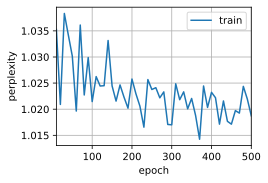

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 139582.2 词元/秒 cuda:0
time travellerit s against reason said filbywhu wilknd at we con
travellerit s against reason said filbywhu wilknd at we con


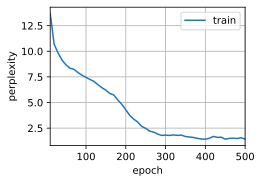

In [15]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)